In [1]:
# !pip install pystan==2.19.1.1
# !pip install fbprophet
# !pip install plotly

# data path in VM local file system: home/data/in/ggtrends_downloads, home/data/in/weather_downloads
# data path in HDFS: hdfs://cluster-bda4-m/user/root/project/data/in/ggtrends, hdfs://cluster-bda4-m/user/root/project/data/in/weather

# To upload data from VM local file system to HDFS execute command similar to the following one:
# hdfs dfs -copyFromLocal home/data/in/ggtrends_downloads/Instagram_Hamburg_historic.csv hdfs://cluster-bda4-m/user/root/project/data/in/ggtrends

In [2]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import Window
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import FloatType

from fbprophet import Prophet

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def symmetric_mean_absolute_percentage_error(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

In [4]:
spark = SparkSession \
    .builder \
    .appName("Time series data analysis with Spark") \
    .config("spark.redis.ssl", "true") \
    .getOrCreate()

## Data processing

In [5]:
_weather_df1 = spark.read.csv("hdfs://cluster-bda4-m/user/root/project/data/in/weather/merged_historic_Hamburg_batch1.csv", inferSchema="true", header="true")
_weather_df2 = spark.read.csv("hdfs://cluster-bda4-m/user/root/project/data/in/weather/merged_historic_Hamburg_batch2.csv", inferSchema="true", header="true")
_weather_df3 = spark.read.csv("hdfs://cluster-bda4-m/user/root/project/data/in/weather/merged_historic_Hamburg_batch3.csv", inferSchema="true", header="true")
_weather_df4 = spark.read.csv("hdfs://cluster-bda4-m/user/root/project/data/in/weather/merged_historic_Hamburg_batch4.csv", inferSchema="true", header="true")
_website_df = spark.read.csv("hdfs://cluster-bda4-m/user/root/project/data/in/ggtrends/Instagram_Hamburg_historic.csv", inferSchema="true", header="true")


dfs = [_weather_df1,_weather_df2,_weather_df3,_weather_df4]
weather_df = reduce(DataFrame.unionAll, dfs)
weather_df = weather_df.withColumnRenamed("Date time", "date")
weather_df = weather_df.withColumn("date", F.to_timestamp(F.col("date"),"MM/dd/yyyy HH:mm:ss").alias("date"))

website_df = _website_df.select(F.to_timestamp(F.col("date"),"MM-dd-yyyy").alias("date"), F.col("value").alias("y"))

In [6]:
website_df.show()

+-------------------+---+
|               date|  y|
+-------------------+---+
|2020-10-01 00:00:00| 23|
|2020-10-01 01:00:00| 36|
|2020-10-01 02:00:00| 38|
|2020-10-01 03:00:00|-45|
|2020-10-01 04:00:00|-14|
|2020-10-01 05:00:00| -7|
|2020-10-01 06:00:00|  4|
|2020-10-01 07:00:00|  1|
|2020-10-01 08:00:00|  0|
|2020-10-01 09:00:00|  1|
|2020-10-01 10:00:00| -5|
|2020-10-01 11:00:00|  4|
|2020-10-01 12:00:00|  1|
|2020-10-01 13:00:00|  4|
|2020-10-01 14:00:00|  3|
|2020-10-01 15:00:00|  0|
|2020-10-01 16:00:00|  0|
|2020-10-01 17:00:00|  0|
|2020-10-01 18:00:00|  2|
|2020-10-01 19:00:00|  4|
+-------------------+---+
only showing top 20 rows



In [7]:
columns = [
    "date",
    "Address",
    "Temperature",
    "Relative Humidity",
    "Wind Speed",
    "Visibility",
    "Cloud Cover",
    "y"]



df = weather_df.join(website_df, how="inner", on="date").select(*columns)
partition = Window.partitionBy("Address").orderBy(F.col("date").asc())
df = df.withColumn("lag1", F.lag("y", 1).over(partition))
df = df.withColumn("lag24", F.lag("y", 24).over(partition)).drop("Address").na.drop(subset=["lag1", "lag24"]).na.fill(0)

columns = [
    "date",
    "Temperature",
    "Relative Humidity",
    "Wind Speed",
    "Visibility",
    "lag1",
    "lag24",
    "y"]

_df = df.withColumn("filter_col", F.when(F.date_format(F.col("date"),"HH:mm:ss").between("07:00:00","23:00:00"),"day").otherwise("night"))

In [8]:
# Days
df_day = _df.filter(F.col("filter_col")=="day").drop("filter_F.col")

# train test split
df_day = df_day.withColumn("rank", F.percent_rank().over(Window.partitionBy().orderBy("date")))
df_day_train = df_day.where("rank <= .8").select(*columns).sort('date')
df_day_test = df_day.where("rank > .8").select(*columns).sort('date')

columns_to_scale = columns[1:-1]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
         
pipeline = Pipeline(stages=assemblers + scalers)

scalerModel = pipeline.fit(df_day_train)
_df_day_train_scaled = scalerModel.transform(df_day_train)
_df_day_test_scaled = scalerModel.transform(df_day_test)

names = {x + "_scaled": x for x in columns_to_scale}

firstelement=F.udf(lambda v:float(v[0]),FloatType())
columns_to_select = [F.col("date"), F.col("y")] + [firstelement(c).alias(c) for c in names.keys()]

_df_day_train_scaled = _df_day_train_scaled.select(columns_to_select)
_df_day_test_scaled = _df_day_test_scaled.select(columns_to_select)

names["date"] = "ds"
names["y"] = "y"

df_day_train_scaled = _df_day_train_scaled.select([F.col(c).alias(names[c]) for c in names.keys()])
df_day_test_scaled = _df_day_test_scaled.select([F.col(c).alias(names[c]) for c in names.keys()])

In [9]:
df_day_train_scaled.show()

+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|Temperature|Relative Humidity|Wind Speed|Visibility|      lag1|lag24|                 ds|  y|
+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|  0.5423729|           0.9201|0.21090908|      0.24|0.47738692|0.505|2020-10-02 07:00:00| -3|
|  0.5381356|           0.9288|0.20363636|     0.148|0.48241207|  0.5|2020-10-02 08:00:00| -1|
| 0.54025424|           0.9309|0.24727273|     0.148| 0.4924623|0.505|2020-10-02 09:00:00| -6|
|  0.5487288|           0.9202|0.35090908|      0.14|0.46733668|0.475|2020-10-02 10:00:00|  0|
| 0.56567794|           0.8851|0.32363635|     0.146|0.49748743| 0.52|2020-10-02 11:00:00| -1|
|  0.5762712|            0.855|0.38545454|     0.198| 0.4924623|0.505|2020-10-02 12:00:00|  1|
| 0.59322035|           0.8208|0.32363635|     0.232| 0.5025126| 0.52|2020-10-02 13:00:00| -8|
|  0.6038136|           0.7927| 0.3890909|     0.2

In [10]:
df_day_test_scaled.show()

+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|Temperature|Relative Humidity|Wind Speed|Visibility|      lag1|lag24|                 ds|  y|
+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|  0.6758475|            0.402|0.09090909|       0.0| 0.4723618| 0.47|2022-05-15 14:00:00|  2|
|  0.7012712|           0.3877|0.09818182|       0.0|0.50753766| 0.49|2022-05-15 15:00:00|  2|
| 0.70974576|           0.3913|0.17818181|       0.0|0.50753766| 0.49|2022-05-15 16:00:00|  0|
|  0.7161017|           0.3655|0.15272728|       0.0|0.49748743|  0.5|2022-05-15 17:00:00|  0|
|  0.7161017|           0.3691|0.20727272|       0.0|0.49748743| 0.49|2022-05-15 18:00:00|  0|
|  0.7118644|           0.3887|0.28363636|      0.74|0.49748743|0.515|2022-05-15 19:00:00| -6|
|  0.6885593|           0.4303|0.27454546|       0.0|0.46733668| 0.47|2022-05-15 20:00:00| 11|
|  0.6377119|           0.5427|0.29818183|       0

In [11]:
# Nights
df_night = _df.filter(F.col("filter_col")=="night").drop("filter_F.col")

# train test split
df_night = df_night.withColumn("rank", F.percent_rank().over(Window.partitionBy().orderBy("date")))
df_night_train = df_night.where("rank <= .8").select(*columns).sort('date')
df_night_test = df_night.where("rank > .8").select(*columns).sort('date')

columns_to_scale = columns[1:-1]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
         
pipeline = Pipeline(stages=assemblers + scalers)

scalerModel = pipeline.fit(df_day_train)
_df_night_train_scaled = scalerModel.transform(df_night_train)
_df_night_test_scaled = scalerModel.transform(df_night_test)

names = {x + "_scaled": x for x in columns_to_scale}

firstelement=F.udf(lambda v:float(v[0]),FloatType())
columns_to_select = [F.col("date"), F.col("y")] + [firstelement(c).alias(c) for c in names.keys()]

_df_night_train_scaled = _df_night_train_scaled.select(columns_to_select)
_df_night_test_scaled = _df_night_test_scaled.select(columns_to_select)

names["date"] = "ds"
names["y"] = "y"

df_night_train_scaled = _df_night_train_scaled.select([F.col(c).alias(names[c]) for c in names.keys()])
df_night_test_scaled = _df_night_test_scaled.select([F.col(c).alias(names[c]) for c in names.keys()])

In [12]:
df_night_train_scaled.show()

+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|Temperature|Relative Humidity|Wind Speed|Visibility|      lag1|lag24|                 ds|  y|
+-----------+-----------------+----------+----------+----------+-----+-------------------+---+
|  0.5635593|           0.7861|0.24545455|     0.702|0.56281406|0.615|2020-10-02 00:00:00| 34|
|  0.5635593|           0.8016| 0.2581818|     0.712| 0.6683417| 0.68|2020-10-02 01:00:00|-37|
| 0.55508476|           0.8268|      0.18|     0.602| 0.3115578| 0.69|2020-10-02 02:00:00| 16|
|  0.5508475|           0.8442|0.19090909|     0.592|0.57788944|0.275|2020-10-02 03:00:00|-55|
|  0.5508475|           0.8563| 0.1509091|      0.56|0.22110553| 0.43|2020-10-02 04:00:00|  0|
|  0.5466102|           0.8893|0.11818182|     0.498|0.49748743|0.465|2020-10-02 05:00:00| -6|
|  0.5423729|            0.917|0.16909091|     0.362|0.46733668| 0.52|2020-10-02 06:00:00| -4|
| 0.55932206|           0.8646|0.31454545|     0.3

In [13]:
df_night_test_scaled.show()

+-----------+-----------------+-----------+----------+-------------+-----+-------------------+----+
|Temperature|Relative Humidity| Wind Speed|Visibility|         lag1|lag24|                 ds|   y|
+-----------+-----------------+-----------+----------+-------------+-----+-------------------+----+
|  0.4088983|           0.9783| 0.02909091|     0.274|          1.0|  0.5|2022-05-15 03:00:00|   0|
| 0.40254238|           0.9713|0.036363635|     0.222|   0.49748743|0.605|2022-05-15 04:00:00| -21|
| 0.39194915|           0.9818|0.036363635|     0.086|    0.3919598| 0.45|2022-05-15 05:00:00|   0|
| 0.40254238|           0.9932| 0.02909091|       0.0|   0.49748743|0.525|2022-05-15 06:00:00|  -1|
|  0.5423729|           0.6296| 0.19454545|       0.0|   0.49748743| 0.59|2022-05-16 00:00:00| -18|
| 0.52330506|            0.679| 0.13272727|       0.0|   0.40703517|  0.5|2022-05-16 01:00:00|   0|
|  0.5084746|           0.7143| 0.14909092|       0.0|   0.49748743|  1.0|2022-05-16 02:00:00|-100|


## Model training & inference

In [14]:
# Days
m1 = Prophet()
for c in df_day_train_scaled.columns[:-2]:
    m1.add_regressor(c)

m1.fit(df_day_train_scaled.toPandas())

# Nights
m2 = Prophet()
for c in df_night_train_scaled.columns[:-2]:
    m2.add_regressor(c)

m2.fit(df_night_train_scaled.toPandas())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [15]:
# Predict
pred_day_train = m1.predict(df_day_train_scaled.toPandas())
pred_day_test = m1.predict(df_day_test_scaled.toPandas())

pred_night_train = m2.predict(df_night_train_scaled.toPandas())
pred_night_test = m2.predict(df_night_test_scaled.toPandas())

In [16]:
pred_train = pd.concat([pred_day_train[["ds", "yhat", "yhat_lower", "yhat_upper"]], pred_night_train[["ds", "yhat", "yhat_lower", "yhat_upper"]]])
pred_test = pd.concat([pred_day_test[["ds", "yhat", "yhat_lower", "yhat_upper"]], pred_night_test[["ds", "yhat", "yhat_lower", "yhat_upper"]]])
train_summary = pred_train.merge(
    pd.concat([df_day_train_scaled.select("ds", "y").toPandas(),
              df_night_train_scaled.select("ds", "y").toPandas()]),
    on="ds")
test_summary = pred_test.merge(
    pd.concat([df_day_test_scaled.select("ds", "y").toPandas(),
              df_night_test_scaled.select("ds", "y").toPandas()]),
    on="ds")

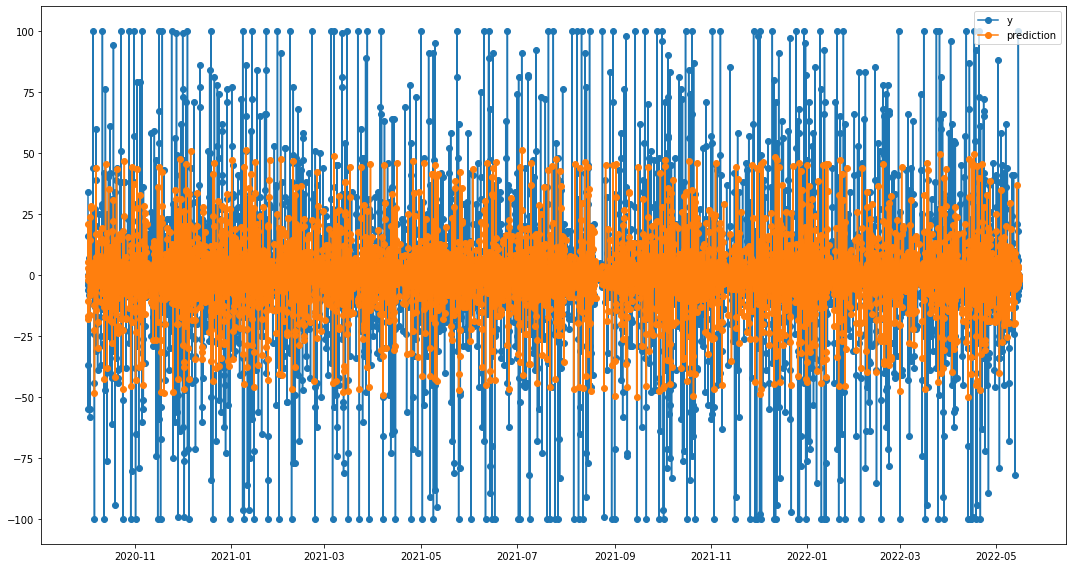

In [17]:
# train
fig, ax = plt.subplots(figsize=(15, 8))
kws = dict(marker="o")
ax.plot(train_summary.set_index("ds").sort_index().y, label="y", **kws)
ax.plot(train_summary.set_index("ds").sort_index().yhat, label="prediction", **kws)
ax.legend()
fig.tight_layout()

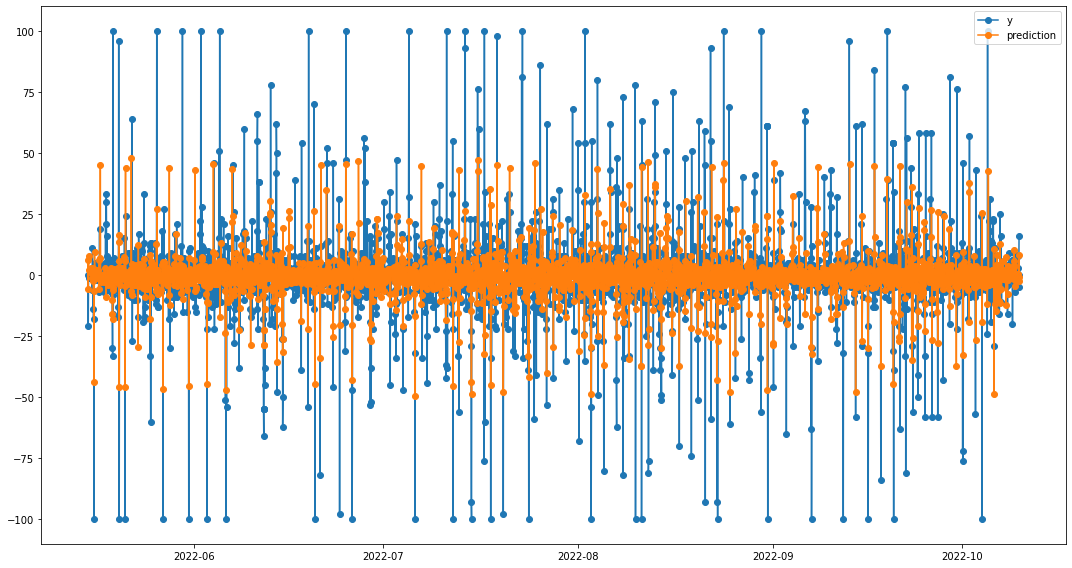

In [18]:
# test
fig, ax = plt.subplots(figsize=(15, 8))
kws = dict(marker="o")
ax.plot(test_summary.set_index("ds").sort_index().y, label="y", **kws)
ax.plot(test_summary.set_index("ds").sort_index().yhat, label="prediction", **kws)
ax.legend()
fig.tight_layout()

In [19]:
# error on train
symmetric_mean_absolute_percentage_error(
    A=np.array(train_summary.y),
    F=np.array(train_summary.yhat))

150.7340959660258

In [20]:
# error on test
symmetric_mean_absolute_percentage_error(
    A=np.array(test_summary.y),
    F=np.array(test_summary.yhat))

148.67116152634753

## Classification

In [21]:
# !pip install --upgrade pretty-confusion-matrix --user

In [22]:
from sklearn import metrics
import seaborn as sns
from pretty_confusion_matrix import pp_matrix

In [23]:
def assign_class(value):
    for _range, _class in decision_boundaries.items():
        # for every pair that you see in table
        if _range[0] <= value < _range[1]:
            return _class

<AxesSubplot:xlabel='y', ylabel='Density'>

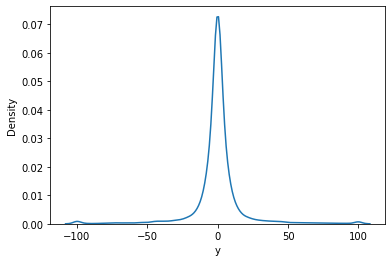

In [24]:
sns.kdeplot(train_summary.y)

<AxesSubplot:xlabel='y', ylabel='Density'>

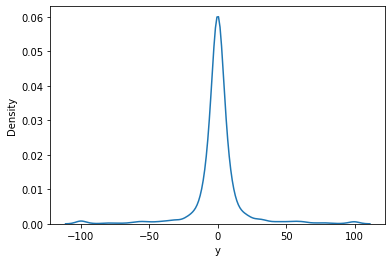

In [25]:
sns.kdeplot(test_summary.y)

In [26]:
train_summary.y.quantile(0.95)

22.0

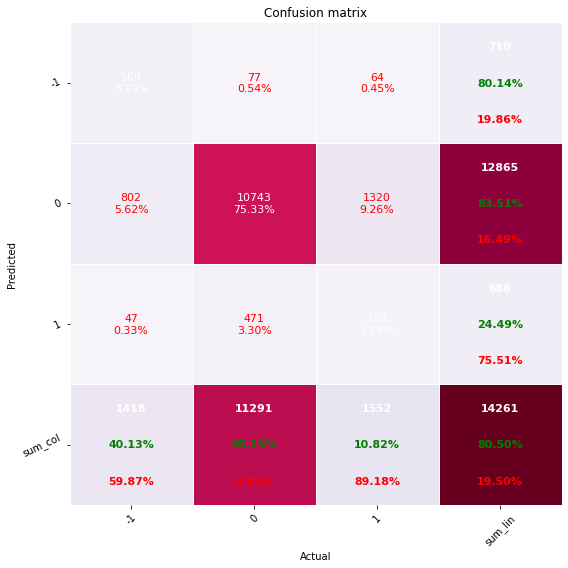

In [27]:
# changes to frame the regression problem as a classification problem & evaluation on train set
decision_boundaries = {
    (-np.inf, -train_summary.y.quantile(0.9)): -1,
    (-train_summary.y.quantile(0.9), train_summary.y.quantile(0.9)): 0,
    (train_summary.y.quantile(0.9), np.inf): 1,
}

train_summary["class"] = train_summary.y.apply(assign_class)
train_summary["pred_class"] = train_summary.yhat.apply(assign_class)

y_train_true = train_summary["class"]
y_train_pred = train_summary["pred_class"]

array = metrics.confusion_matrix(y_train_true, y_train_pred)
df_cm = pd.DataFrame(
    array,
    index=decision_boundaries.values(),
    columns=decision_boundaries.values(),
)
cmap = "PuRd"
pp_matrix(df_cm, cmap=cmap)

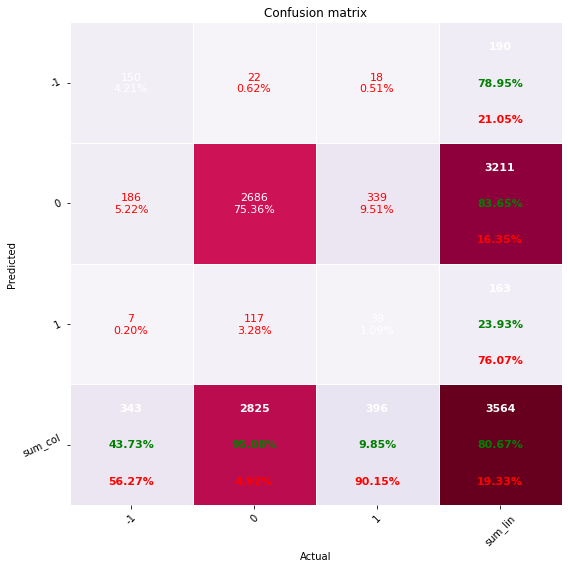

In [28]:
# changes to frame the regression problem as a classification problem & evaluation on test set
decision_boundaries = {
    (-np.inf, -test_summary.y.quantile(0.9)): -1,
    (-test_summary.y.quantile(0.9), test_summary.y.quantile(0.9)): 0,
    (test_summary.y.quantile(0.9), np.inf): 1
}

test_summary['class'] = test_summary.y.apply(assign_class)
test_summary['pred_class'] = test_summary.yhat.apply(assign_class)

y_test_true = test_summary['class']
y_test_pred = test_summary['pred_class']

array = metrics.confusion_matrix(y_test_true, y_test_pred)
df_cm = pd.DataFrame(array, index=decision_boundaries.values(), columns=decision_boundaries.values())
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)